##### Copyright 2019 The TensorFlow Authors.

In [18]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Convolutional Neural Network (CNN)

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/cnn">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/cnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates training a simple [Convolutional Neural Network](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) (CNN) to classify [CIFAR images](https://www.cs.toronto.edu/~kriz/cifar.html). Because this tutorial uses the [Keras Sequential API](https://www.tensorflow.org/guide/keras/overview), creating and training your model will take just a few lines of code.


### Import TensorFlow

In [19]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import keras_tuner


In [20]:
#!/usr/bin/env python3
# SPDX-License-Identifier: BSD-2-Clause
# Copyright (c) 2018 Jakub Červený
# https://github.com/jakubcerveny/gilbert/tree/master


def gilbert2d(width, height):
    """
    Generalized Hilbert ('gilbert') space-filling curve for arbitrary-sized
    2D rectangular grids. Generates discrete 2D coordinates to fill a rectangle
    of size (width x height).
    """

    if width >= height:
        yield from generate2d(0, 0, width, 0, 0, height)
    else:
        yield from generate2d(0, 0, 0, height, width, 0)


def sgn(x):
    return -1 if x < 0 else (1 if x > 0 else 0)


def generate2d(x, y, ax, ay, bx, by):

    w = abs(ax + ay)
    h = abs(bx + by)

    (dax, day) = (sgn(ax), sgn(ay)) # unit major direction
    (dbx, dby) = (sgn(bx), sgn(by)) # unit orthogonal direction

    if h == 1:
        # trivial row fill
        for i in range(0, w):
            yield(x, y)
            (x, y) = (x + dax, y + day)
        return

    if w == 1:
        # trivial column fill
        for i in range(0, h):
            yield(x, y)
            (x, y) = (x + dbx, y + dby)
        return

    (ax2, ay2) = (ax//2, ay//2)
    (bx2, by2) = (bx//2, by//2)

    w2 = abs(ax2 + ay2)
    h2 = abs(bx2 + by2)

    if 2*w > 3*h:
        if (w2 % 2) and (w > 2):
            # prefer even steps
            (ax2, ay2) = (ax2 + dax, ay2 + day)

        # long case: split in two parts only
        yield from generate2d(x, y, ax2, ay2, bx, by)
        yield from generate2d(x+ax2, y+ay2, ax-ax2, ay-ay2, bx, by)

    else:
        if (h2 % 2) and (h > 2):
            # prefer even steps
            (bx2, by2) = (bx2 + dbx, by2 + dby)

        # standard case: one step up, one long horizontal, one step down
        yield from generate2d(x, y, bx2, by2, ax2, ay2)
        yield from generate2d(x+bx2, y+by2, ax, ay, bx-bx2, by-by2)
        yield from generate2d(x+(ax-dax)+(bx2-dbx), y+(ay-day)+(by2-dby),
                              -bx2, -by2, -(ax-ax2), -(ay-ay2))


### Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [21]:
#first see if the train and test images are already created

train_images, train_images_orig, train_labels, test_images, test_images_orig, test_labels = None, None, None, None, None, None


try:
    train_images = np.load('train_images.npy')
    test_images = np.load('test_images.npy')
    train_images_orig = np.load('train_images_orig.npy')
    test_images_orig = np.load('test_images_orig.npy')
    train_labels = np.load('train_labels.npy')
    test_labels = np.load('test_labels.npy')
    
except:
    train_images = None
    test_images = None

if train_images is None :
    (train_images_orig, train_labels), (test_images_orig, test_labels) = datasets.cifar10.load_data()

    train_images = np.zeros((train_images_orig.shape[0], 32,32,3))
    test_images = np.zeros((test_images_orig.shape[0], 32,32,3))

    gilbert_curve = list(gilbert2d(32, 32))


    for i in range(train_images_orig.shape[0]):
        #index through the images starting from bottom left
        a,b = 0,0
        #loop through the gilbert curve
        for j, (x, y) in enumerate(gilbert_curve):
            #set the pixel value of the train_images to the pixel value of the train_images_orig
            train_images[i][x][y][0] = train_images_orig[i][a][b][0]
            train_images[i][x][y][1] = train_images_orig[i][a][b][1]
            train_images[i][x][y][2] = train_images_orig[i][a][b][2]
            #increment the index of the train_images_orig
            a += 1
            if a == 32:
                b += 1
                a = 0

    for i in range(test_images_orig.shape[0]):
        #index through the images starting from bottom left
        a,b = 0,0
        #loop through the gilbert curve
        for j, (x, y) in enumerate(gilbert_curve):
            #set the pixel value of the train_images to the pixel value of the train_images_orig
            test_images[i][x][y][0] = test_images_orig[i][a][b][0]
            test_images[i][x][y][1] = test_images_orig[i][a][b][1]
            test_images[i][x][y][2] = test_images_orig[i][a][b][2]
            #increment the index of the train_images_orig
            a += 1
            if a == 32:
                b += 1
                a = 0


    train_images, test_images = train_images / 255.0, test_images / 255.0

    #save the train and test images
    np.save('train_images.npy', train_images)
    np.save('train_images_orig.npy', train_images_orig)
    np.save('test_images.npy', test_images)
    np.save('test_images_orig.npy', test_images_orig)
    np.save('train_labels.npy', train_labels)
    np.save('test_labels.npy', test_labels)





### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:


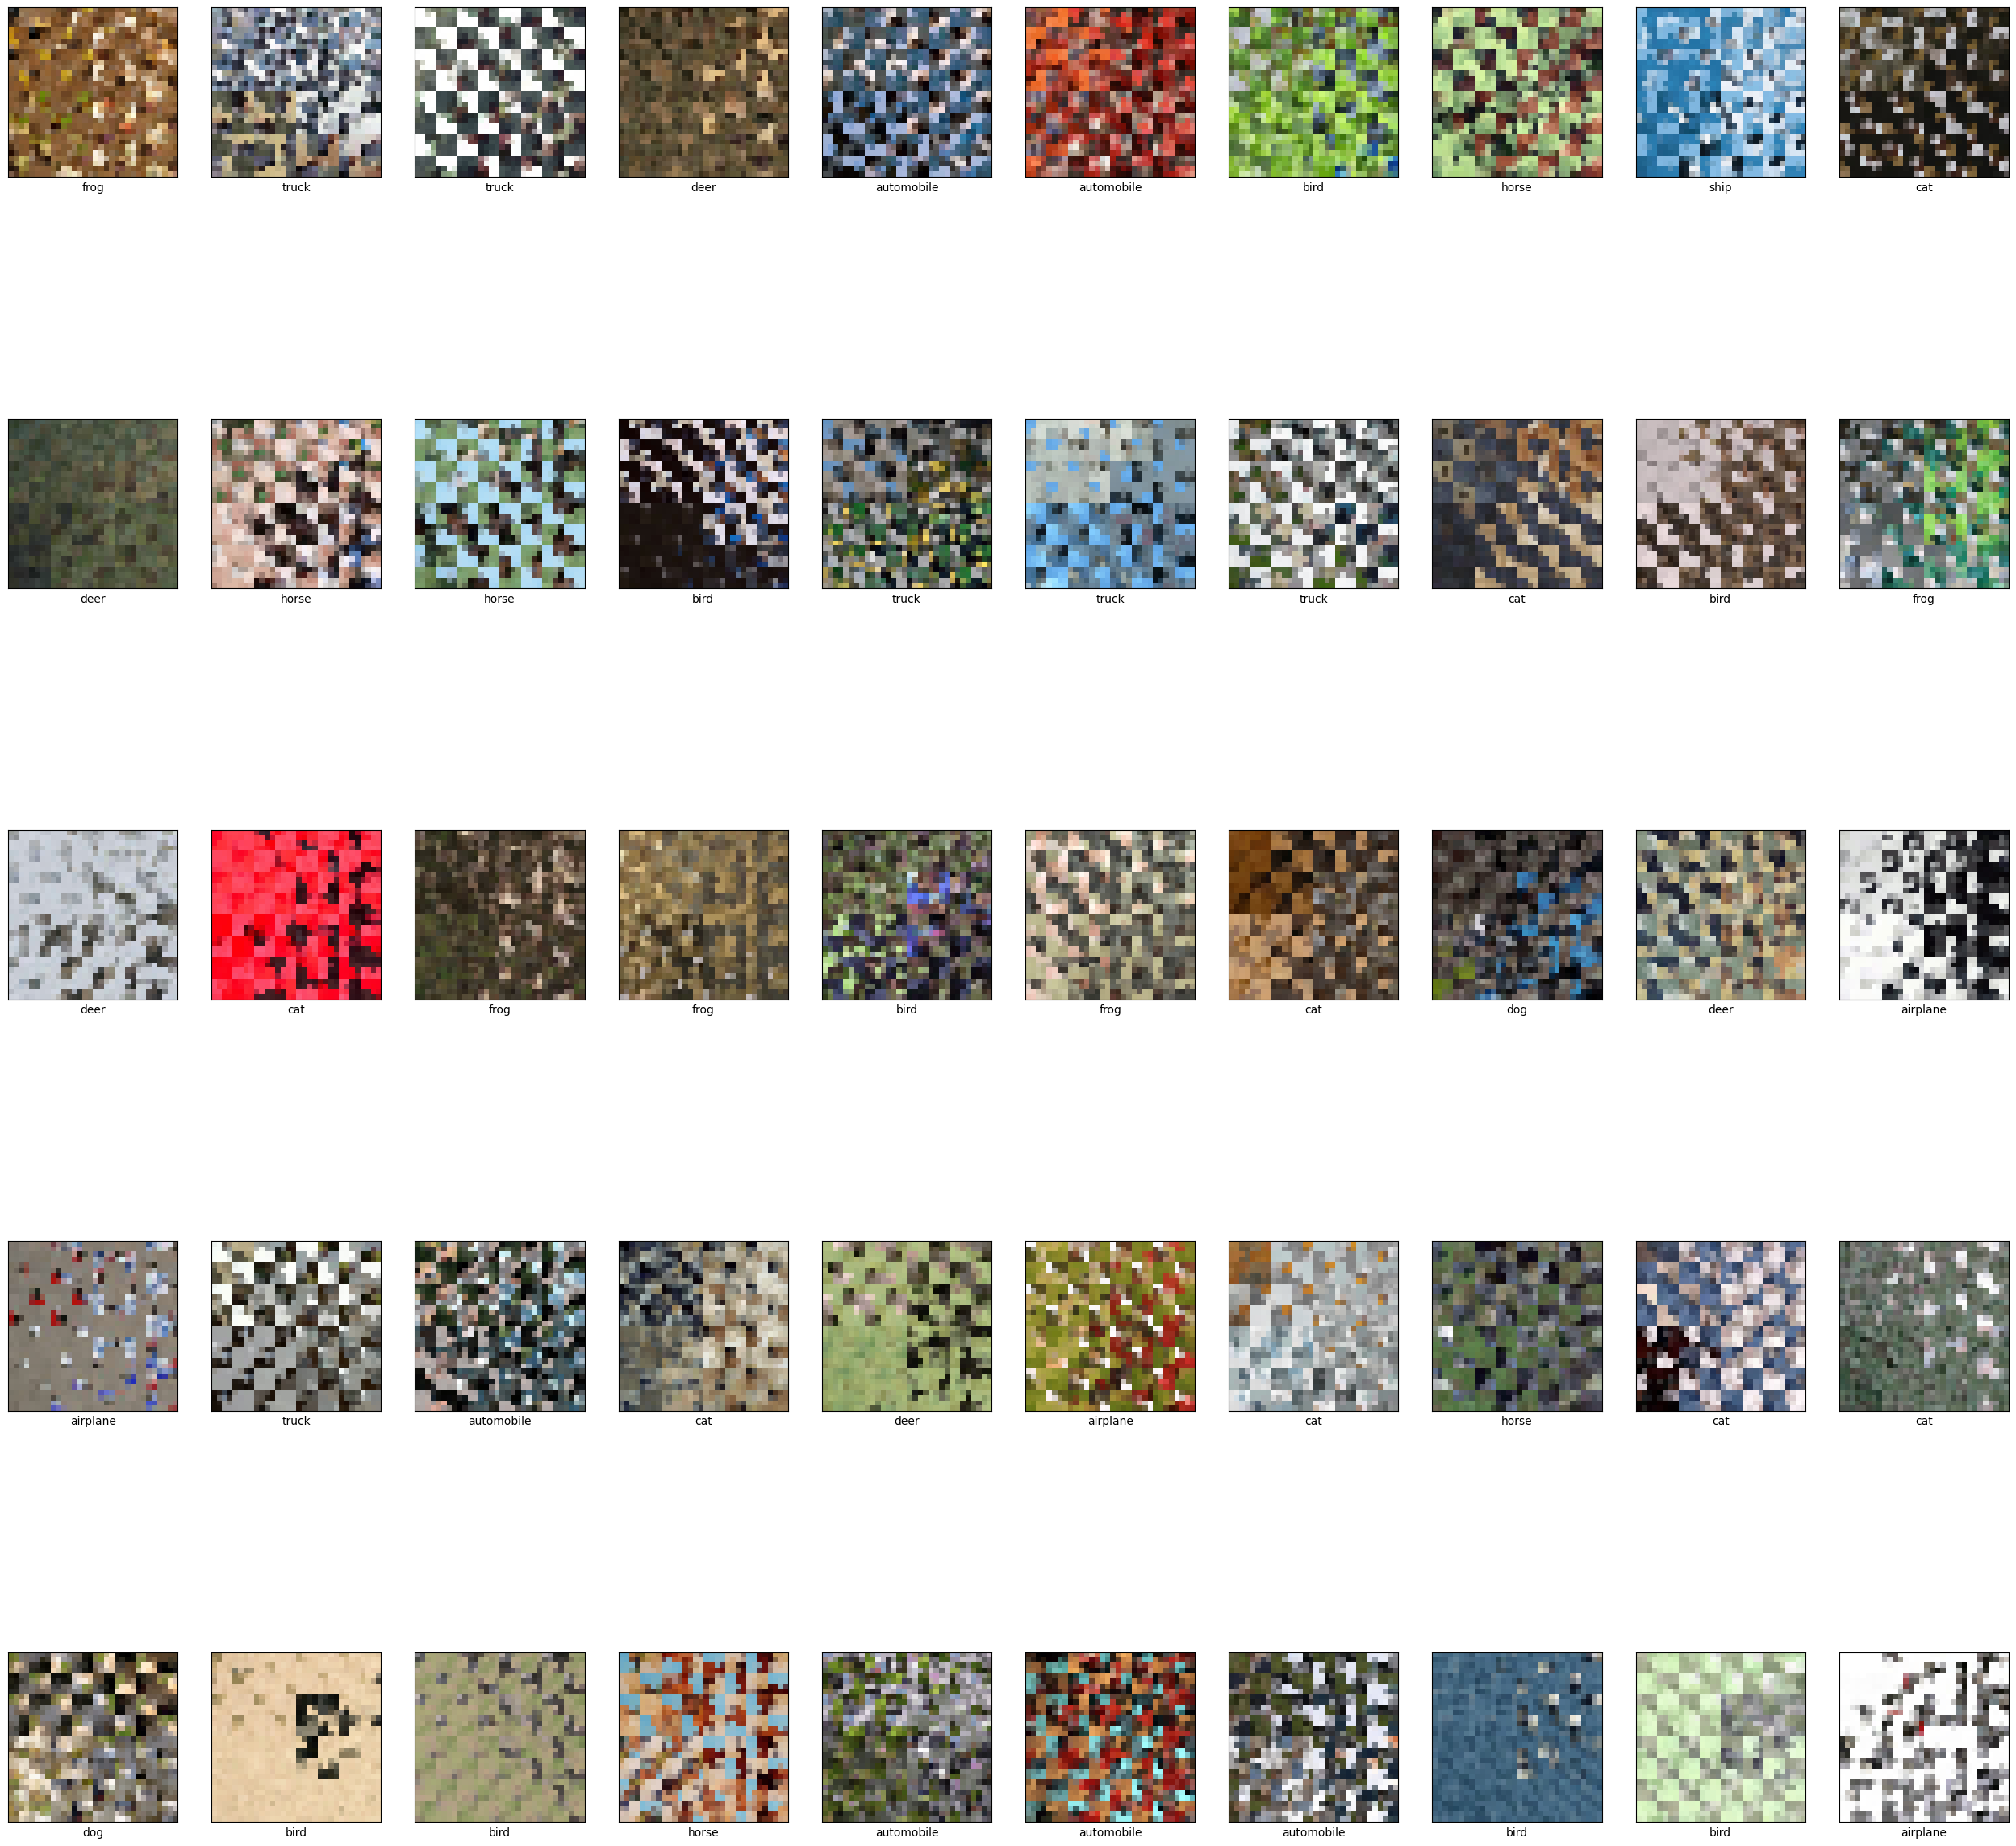

In [22]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(32,32))
for i in range(50):
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to your first layer.


In [23]:
def build_model(hp):

    primary_filter_size = hp.Choice('filter_size',[3,4,5])
    secondary_filter_size = hp.Choice('secondary_filter_size',[3,4,5])
    tertiary_filter_size = hp.Choice('tertiary_filter_size',[3,4,5])

    model = models.Sequential()
    model.add(layers.Conv2D(32, 
                            (primary_filter_size, primary_filter_size),
                            activation=hp.Choice('layer_1_activation',['relu','tanh']), 
                            input_shape=(32, 32, 3)))
    model.add(layers.AveragePooling2D((2, 2)))
    model.add(layers.Conv2D(64, 
                            (secondary_filter_size, secondary_filter_size), 
                            activation=hp.Choice('layer_2_activation',['relu','tanh'])))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, 
                            (tertiary_filter_size, tertiary_filter_size), 
                            activation=hp.Choice('layer_3_activation',['relu','tanh'])))
    model.add(layers.Flatten())
    model.add(layers.Dense(hp.Int('dense_1_units', min_value=32, max_value=256, step=32),
                           activation=hp.Choice('dense_1_activation',['relu','tanh'])))
    model.add(layers.Dense(10))
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    print("Model to be built:")
    print(model.summary())

    return model


The network summary shows that (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

### Compile and train the model

In [24]:
tuner = keras_tuner.tuners.RandomSearch(
    hypermodel=build_model,
    objective='val_accuracy',
    max_trials=100,
    directory='hilbert',
)

tuner.search(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

tuner.results_summary()

Trial 68 Complete [00h 03m 36s]
val_accuracy: 0.5435000061988831

Best val_accuracy So Far: 0.569599986076355
Total elapsed time: 05h 12m 50s

Search: Running Trial #69

Value             |Best Value So Far |Hyperparameter
4                 |3                 |filter_size
5                 |3                 |secondary_filter_size
3                 |4                 |tertiary_filter_size
tanh              |relu              |layer_1_activation
relu              |tanh              |layer_2_activation
relu              |tanh              |layer_3_activation
32                |256               |dense_1_units
tanh              |relu              |dense_1_activation

Model to be built:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 29, 29, 32)     │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 14, 14, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,554 (424.04 KB)

 Trainable params: 108,554 (424.04 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.3236 - loss: 1.8536 - val_accuracy: 0.4476 - val_loss: 1.5156
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.4669 - loss: 1.4904 - val_accuracy: 0.4797 - val_loss: 1.4369
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.5043 - loss: 1.3792 - val_accuracy: 0.5075 - val_loss: 1.3713
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.5348 - loss: 1.3022 - val_accuracy: 0.5113 - val_loss: 1.3619
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.5575 - loss: 1.2410 - val_accuracy: 0.5157 - val_loss: 1.3415
Epoch 6/10
1079/1563 ━━━━━━━━━━━━━━━━━━━━ 3:56 489ms/step - accuracy: 0.5813 - loss: 1.1957

KeyboardInterrupt: 